In [1]:
import pandas as pd

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# Motivation
We will use sales dataset and will predict next day/week sales using linear regression.

In [2]:
# read csv file
df = pd.read_csv("data/sales.csv")
item = pd.read_csv("data/items.csv")

# check random samples
df.sample(5)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
2719282,16.07.2015,30,5,7834,799.00,1.0
2049474,20.10.2014,21,12,17640,399.00,1.0
1145275,05.12.2013,11,28,16501,399.00,1.0
2889689,31.10.2015,33,35,6728,932.66,1.0
439341,01.04.2013,3,41,1921,249.00,1.0


In [3]:
item.sample(5)

,item_name,item_id,item_category_id
11830,Звери Лучшее на MP3 (mp3-CD) (jewel),11830,57
12875,КРАСНЫЙ БАРОН э (BD),12875,37
2288,Call of Duty: Advanced Warfare. Atlas Limited ...,2288,28
15554,НАИВ Alter Ego DVD+CD,15554,59
21244,Футболка The Elder Scrolls Online Elf XL,21244,61


In [4]:
# drop item_name
item = item.drop('item_name', axis=1)
item.sample(5)

,item_id,item_category_id
1432,1432,31
12878,12878,40
12637,12637,58
20385,20385,72
19762,19762,40


In [5]:
df = df.merge(item, on='item_id', how='left')
df.sample(5)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
648931,03.07.2013,6,31,12068,399.0,1.0,37
1619055,21.04.2014,15,29,14228,99.0,1.0,30
649727,17.07.2013,6,31,13905,349.0,1.0,55
413301,21.04.2013,3,31,14303,399.0,1.0,40
1980302,22.09.2014,20,25,18685,199.0,1.0,55


## Data 

We got 6 columns. 

- ### Categorical 
`shop_id`, `item_id`, `item_category_id`

- ### Numerical 
`item_price`, `item_cnt_day`

## DataType

Let's check datatype and memory usage of data

In [6]:
# col DataType and memory usage 
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2935849 entries, 0 to 2935848
Data columns (total 7 columns):
 #   Column            Dtype  
---  ------            -----  
 0   date              object 
 1   date_block_num    int64  
 2   shop_id           int64  
 3   item_id           int64  
 4   item_price        float64
 5   item_cnt_day      float64
 6   item_category_id  int64  
dtypes: float64(2), int64(4), object(1)
memory usage: 179.2+ MB


In [7]:
# downcast and reduce memory usages
for col in df.columns:
    if df[col].dtype=='int64':
        df[col] = pd.to_numeric(df[col], downcast='integer')
    elif df[col].dtype=='float64':
        df[col] = pd.to_numeric(df[col], downcast='float')

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2935849 entries, 0 to 2935848
Data columns (total 7 columns):
 #   Column            Dtype  
---  ------            -----  
 0   date              object 
 1   date_block_num    int8   
 2   shop_id           int8   
 3   item_id           int16  
 4   item_price        float32
 5   item_cnt_day      float32
 6   item_category_id  int8   
dtypes: float32(2), int16(1), int8(3), object(1)
memory usage: 81.2+ MB


In [8]:
# datetime 
df['date'] = pd.to_datetime(df['date'])

**We reduce the memory usage by downcast.**

## Missing value

In [9]:
# missing value 
for col in df.columns:
    print(col,">>",df[col].isnull().sum())

date >> 0
date_block_num >> 0
shop_id >> 0
item_id >> 0
item_price >> 0
item_cnt_day >> 0
item_category_id >> 0


**No missing value to handle**

## Prepare Features & Target

In [10]:
# new col price 
df['price'] = df['item_price']*df['item_cnt_day']
df.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id,price
0,2013-02-01,0,59,22154,999.000000,1.0,37,999.000000
1,2013-03-01,0,25,2552,899.000000,1.0,58,899.000000
2,2013-05-01,0,25,2552,899.000000,-1.0,58,-899.000000
3,2013-06-01,0,25,2554,1709.050049,1.0,58,1709.050049
4,2013-01-15,0,25,2555,1099.000000,1.0,56,1099.000000


In [11]:
def target(data, shift_value=1):
    data = data.sort_values(by='date')
    data['target'] = data['price'].shift(-shift_value)
    return data

# feature data
data = df.groupby(['date', 'shop_id'])['item_cnt_day', 'price'].sum().reset_index()
print(data.shape)
data.head()

,date,shop_id,item_cnt_day,price
0,2013-01-01,2,24.0,31886.0
1,2013-01-01,7,89.0,59993.0
2,2013-01-01,8,50.0,44516.0
3,2013-01-01,13,31.0,6043.0
4,2013-01-01,14,66.0,48847.0


In [12]:
data = data.groupby(['shop_id'], group_keys=False).apply(target).reset_index()
print(df.shape)
data.head()

,index,date,shop_id,item_cnt_day,price,target
0,17,2013-01-02,0,228.0,149282.0,90495.0
1,508,2013-01-13,0,144.0,90495.0,62599.0
2,553,2013-01-14,0,138.0,62599.0,81450.0
3,598,2013-01-15,0,153.0,81450.0,53509.0
4,643,2013-01-16,0,154.0,53509.0,67057.0
...,...,...,...,...,...,...
47223,47059,2015-12-06,59,31.0,19075.0,41122.0
47224,47102,2015-12-07,59,51.0,41122.0,13717.0
47225,47144,2015-12-08,59,13.0,13717.0,29827.0
47226,47186,2015-12-09,59,41.0,29827.0,14899.0


In [13]:
data.drop('index', axis=1, inplace=True)
data.dropna(inplace=True)
data

,date,shop_id,item_cnt_day,price,target
0,2013-01-02,0,228.0,149282.0,90495.0
1,2013-01-13,0,144.0,90495.0,62599.0
2,2013-01-14,0,138.0,62599.0,81450.0
3,2013-01-15,0,153.0,81450.0,53509.0
4,2013-01-16,0,154.0,53509.0,67057.0
...,...,...,...,...,...
47222,2015-12-05,59,8.0,4859.0,19075.0
47223,2015-12-06,59,31.0,19075.0,41122.0
47224,2015-12-07,59,51.0,41122.0,13717.0
47225,2015-12-08,59,13.0,13717.0,29827.0


## Base model

In [14]:
# split into test and train data
X_train, X_test, y_train, y_test = train_test_split(data.drop(['date', 'target'], axis=1), 
                                                    data['target'], test_size=0.4)

# train model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# prediction
prediction = lr_model.predict(X_test)

# The coefficients
print('Coefficients: \n', lr_model.coef_)

# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y_test, prediction))

# The coefficient of determination: 1 is perfect prediction
print('R2 score: %.2f'
      % r2_score(y_test, prediction))

Coefficients: 
 [-28.61701538 264.21565856   0.38135208]
Mean squared error: 5849858087.15
R2 score: 0.37


## One-hot-encoding

In [15]:
one_hot = pd.get_dummies(data['shop_id'], prefix='shop_id')
data = data.join(one_hot)
data.drop('shop_id', axis=1, inplace=True)
data.head()

,date,item_cnt_day,price,target,shop_id_0,shop_id_1,shop_id_2,shop_id_3,shop_id_4,shop_id_5,...,shop_id_50,shop_id_51,shop_id_52,shop_id_53,shop_id_54,shop_id_55,shop_id_56,shop_id_57,shop_id_58,shop_id_59
0,2013-01-02,228.0,149282.0,90495.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2013-01-13,144.0,90495.0,62599.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2013-01-14,138.0,62599.0,81450.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2013-01-15,153.0,81450.0,53509.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2013-01-16,154.0,53509.0,67057.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
# split into test and train data
X_train, X_test, y_train, y_test = train_test_split(data.drop(['date', 'target'], axis=1), 
                                                    data['target'], test_size=0.4)

# train model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# prediction
prediction = lr_model.predict(X_test)


coef = pd.DataFrame()
coef['columns'] = data.drop(['date', 'target'],axis=1).columns
coef['Coefficients'] = lr_model.coef_
# The coefficients
print('Coefficients: \n', coef)

# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y_test, prediction))

# The coefficient of determination: 1 is perfect prediction
print('R2 score: %.2f'
      % r2_score(y_test, prediction))

Coefficients: 
          columns  Coefficients
0   item_cnt_day     25.547119
1          price      0.355168
2      shop_id_0  26832.953125
3      shop_id_1 -75799.484375
4      shop_id_2 -34004.843750
..           ...           ...
57    shop_id_55 -21020.312500
58    shop_id_56 -27384.824219
59    shop_id_57  19683.113281
60    shop_id_58 -10743.104492
61    shop_id_59 -29872.654297

[62 rows x 2 columns]
Mean squared error: 4967826944.00
R2 score: 0.40


**Using One-Hot-Encoding for category column shop_id improve our model**

## Transformer

In [17]:
data2 = data.copy()
print(data['item_cnt_day'].min(), data['item_cnt_day'].max())

-2.0 2279.0


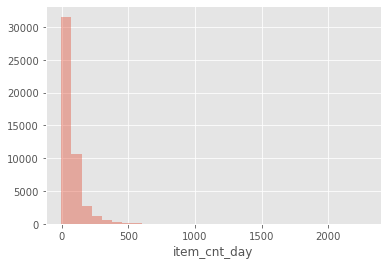

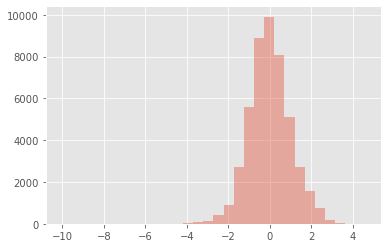

In [18]:
from sklearn.preprocessing import PowerTransformer
pt = PowerTransformer()

sns.distplot(data['item_cnt_day'],bins=30, kde=False)
plt.show()

sns.distplot(pt.fit_transform(data['item_cnt_day'].values.reshape(-1, 1)),bins=30, kde=False)
plt.show()

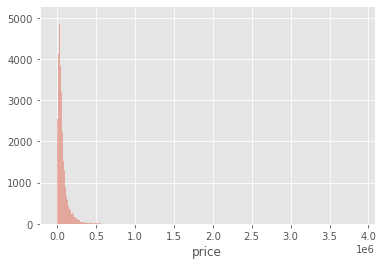

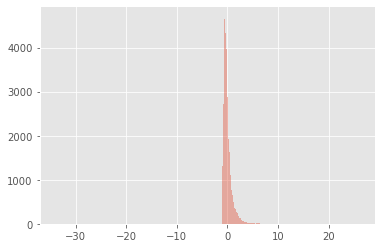

In [19]:
sns.distplot(data['price'],bins=500, kde=False)
plt.show()

y =pt.fit_transform(data['price'].values.reshape(-1, 1))
sns.distplot(y,bins=500, kde=False)
plt.show()

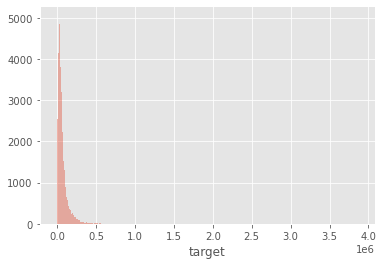

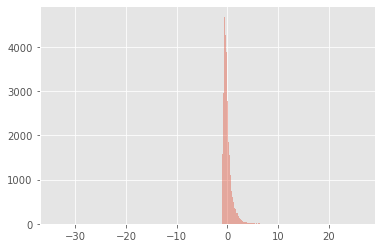

In [20]:
sns.distplot(data['target'],bins=500, kde=False)
plt.show()

y = pt.fit_transform(data['target'].values.reshape(-1, 1))
sns.distplot(y,bins=500, kde=False)
plt.show()

In [21]:
data['price'] = pt.fit_transform(data['price'].values.reshape(-1, 1))
data['target'] = pt.fit_transform(data['target'].values.reshape(-1, 1))
data['item_cnt_day'] = pt.fit_transform(data['item_cnt_day'].values.reshape(-1, 1))
data

,date,item_cnt_day,price,target,shop_id_0,shop_id_1,shop_id_2,shop_id_3,shop_id_4,shop_id_5,...,shop_id_50,shop_id_51,shop_id_52,shop_id_53,shop_id_54,shop_id_55,shop_id_56,shop_id_57,shop_id_58,shop_id_59
0,2013-01-02,1.754250,1.018238,0.326627,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2013-01-13,1.184653,0.326415,-0.035119,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2013-01-14,1.131955,-0.035509,0.212452,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2013-01-15,1.259740,0.212185,-0.160239,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2013-01-16,1.267817,-0.160692,0.024758,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47222,2015-12-05,-2.284827,-0.974382,-0.691473,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
47223,2015-12-06,-0.700303,-0.692216,-0.338680,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
47224,2015-12-07,-0.094321,-0.339227,-0.788979,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
47225,2015-12-08,-1.732662,-0.789779,-0.512105,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [22]:
# split into test and train data
X_train, X_test, y_train, y_test = train_test_split(data.drop(['date', 'target'], axis=1), 
                                                    data['target'], test_size=0.4)

# train model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# prediction
prediction = lr_model.predict(X_test)


coef = pd.DataFrame()
coef['columns'] = data.drop(['date', 'target'],axis=1).columns
coef['Coefficients'] = lr_model.coef_
# The coefficients
print('Coefficients: \n', coef)

# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y_test, prediction))

# The coefficient of determination: 1 is perfect prediction
print('R2 score: %.2f'
      % r2_score(y_test, prediction))

Coefficients: 
          columns  Coefficients
0   item_cnt_day      0.005512
1          price      0.348572
2      shop_id_0    -23.505026
3      shop_id_1    -23.952568
4      shop_id_2    -24.105816
..           ...           ...
57    shop_id_55    -24.049299
58    shop_id_56    -23.994917
59    shop_id_57    -23.490818
60    shop_id_58    -23.850468
61    shop_id_59    -24.121134

[62 rows x 2 columns]
Mean squared error: 0.49
R2 score: 0.45


## More EDA

In [23]:
df

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id,price
0,2013-02-01,0,59,22154,999.000000,1.0,37,999.000000
1,2013-03-01,0,25,2552,899.000000,1.0,58,899.000000
2,2013-05-01,0,25,2552,899.000000,-1.0,58,-899.000000
3,2013-06-01,0,25,2554,1709.050049,1.0,58,1709.050049
4,2013-01-15,0,25,2555,1099.000000,1.0,56,1099.000000
...,...,...,...,...,...,...,...,...
2935844,2015-10-10,33,25,7409,299.000000,1.0,55,299.000000
2935845,2015-09-10,33,25,7460,299.000000,1.0,55,299.000000
2935846,2015-10-14,33,25,7459,349.000000,1.0,55,349.000000
2935847,2015-10-22,33,25,7440,299.000000,1.0,57,299.000000


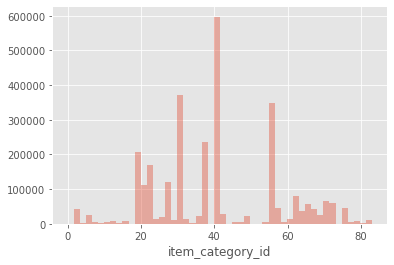

In [24]:
sns.distplot(df['item_category_id'],bins=50, kde=False)
plt.show()

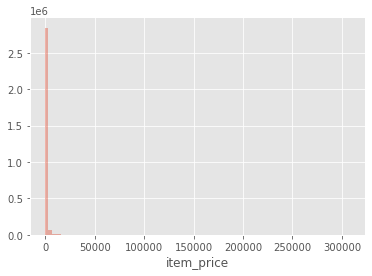

In [25]:
sns.distplot(df['item_price'],bins=100, kde=False)
plt.show()

In [26]:
# df.groupby(['item_category_id','date','shop_id'])['item_price'].sum().reset_index()
df['item_price'].min(), df['item_price'].max(), df['item_price'].mean()

(-1.0, 307980.0, 890.8532)

In [27]:
cut_labels = ['low', 'mid', 'high', 'super-high']
cut_bins = [-2, 10, 1000, 10000, 307981]

df['price_category'] = pd.cut(df['item_price'], bins=cut_bins, labels=cut_labels)
df.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id,price,price_category
0,2013-02-01,0,59,22154,999.000000,1.0,37,999.000000,mid
1,2013-03-01,0,25,2552,899.000000,1.0,58,899.000000,mid
2,2013-05-01,0,25,2552,899.000000,-1.0,58,-899.000000,mid
3,2013-06-01,0,25,2554,1709.050049,1.0,58,1709.050049,high
4,2013-01-15,0,25,2555,1099.000000,1.0,56,1099.000000,high
...,...,...,...,...,...,...,...,...,...
2935844,2015-10-10,33,25,7409,299.000000,1.0,55,299.000000,mid
2935845,2015-09-10,33,25,7460,299.000000,1.0,55,299.000000,mid
2935846,2015-10-14,33,25,7459,349.000000,1.0,55,349.000000,mid
2935847,2015-10-22,33,25,7440,299.000000,1.0,57,299.000000,mid


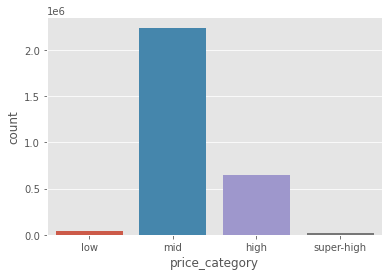

In [28]:
sns.countplot('price_category',data=df)
plt.show()

In [29]:
def price_category(temp):
#     print(temp)
    d = {}
    d['mid_count'] = temp[temp['price_category']=='mid']['item_cnt_day'].sum()
    d['high_count'] = temp[temp['price_category']=='high']['item_cnt_day'].sum()
    d['low_count'] = temp[temp['price_category']=='low']['item_cnt_day'].sum()
    d['super_high_count'] = temp[temp['price_category']=='super-high']['item_cnt_day'].sum()
    d['price'] = temp['price'].sum()    
    d['item_cnt_day'] = temp['item_cnt_day'].sum()
    return pd.Series(d)

In [32]:
# from tqdm.auto import tqdm
from tqdm import tqdm
tqdm.pandas()
# feature data
data = df.groupby([
    'date','shop_id'],group_keys=False).progress_apply(price_category).reset_index()
# data.dropna(inplace=True)
data.head()

100%|███████████████████████████████████████████████████████████████████████████| 47228/47228 [07:09<00:00, 109.85it/s]


,date,shop_id,mid_count,high_count,low_count,super_high_count,price,item_cnt_day
0,2013-01-01,2,18.0,5.0,0.0,1.0,31886.0,24.0
1,2013-01-01,7,74.0,15.0,0.0,0.0,59993.0,89.0
2,2013-01-01,8,45.0,4.0,0.0,1.0,44516.0,50.0
3,2013-01-01,13,28.0,0.0,3.0,0.0,6043.0,31.0
4,2013-01-01,14,52.0,14.0,0.0,0.0,48847.0,66.0


In [40]:
# data = d.copy()

data = data.groupby(['shop_id'], group_keys=False).apply(target).reset_index()
print(data.shape)
data.head()

(47228, 10)


,index,date,shop_id,mid_count,high_count,low_count,super_high_count,price,item_cnt_day,target
0,17,2013-01-02,0,184.0,43.0,0.0,1.0,149282.0,228.0,90495.0
1,508,2013-01-13,0,125.0,17.0,0.0,2.0,90495.0,144.0,62599.0
2,553,2013-01-14,0,124.0,13.0,0.0,1.0,62599.0,138.0,81450.0
3,598,2013-01-15,0,131.0,21.0,0.0,1.0,81450.0,153.0,53509.0
4,643,2013-01-16,0,140.0,14.0,0.0,0.0,53509.0,154.0,67057.0


In [41]:
data.drop('index', axis=1, inplace=True)
data.dropna(inplace=True)
data

,date,shop_id,mid_count,high_count,low_count,super_high_count,price,item_cnt_day,target
0,2013-01-02,0,184.0,43.0,0.0,1.0,149282.0,228.0,90495.0
1,2013-01-13,0,125.0,17.0,0.0,2.0,90495.0,144.0,62599.0
2,2013-01-14,0,124.0,13.0,0.0,1.0,62599.0,138.0,81450.0
3,2013-01-15,0,131.0,21.0,0.0,1.0,81450.0,153.0,53509.0
4,2013-01-16,0,140.0,14.0,0.0,0.0,53509.0,154.0,67057.0
...,...,...,...,...,...,...,...,...,...
47222,2015-12-05,59,7.0,1.0,0.0,0.0,4859.0,8.0,19075.0
47223,2015-12-06,59,25.0,5.0,1.0,0.0,19075.0,31.0,41122.0
47224,2015-12-07,59,35.0,15.0,1.0,0.0,41122.0,51.0,13717.0
47225,2015-12-08,59,6.0,7.0,0.0,0.0,13717.0,13.0,29827.0


In [42]:
# d = data.copy()
one_hot = pd.get_dummies(data['shop_id'], prefix='shop_id')
data = data.join(one_hot)
data.drop(['shop_id','item_cnt_day'], axis=1, inplace=True)
data.head()

,date,mid_count,high_count,low_count,super_high_count,price,target,shop_id_0,shop_id_1,shop_id_2,...,shop_id_50,shop_id_51,shop_id_52,shop_id_53,shop_id_54,shop_id_55,shop_id_56,shop_id_57,shop_id_58,shop_id_59
0,2013-01-02,184.0,43.0,0.0,1.0,149282.0,90495.0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2013-01-13,125.0,17.0,0.0,2.0,90495.0,62599.0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2013-01-14,124.0,13.0,0.0,1.0,62599.0,81450.0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2013-01-15,131.0,21.0,0.0,1.0,81450.0,53509.0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2013-01-16,140.0,14.0,0.0,0.0,53509.0,67057.0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [43]:
# split into test and train data
X_train, X_test, y_train, y_test = train_test_split(data.drop(['date', 'target'], axis=1), 
                                                    data['target'], test_size=0.4)

# train model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# prediction
prediction = lr_model.predict(X_test)


coef = pd.DataFrame()
coef['columns'] = data.drop(['date', 'target'],axis=1).columns
coef['Coefficients'] = lr_model.coef_
# The coefficients
print('Coefficients: \n', coef)

# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y_test, prediction))

# The coefficient of determination: 1 is perfect prediction
print('R2 score: %.2f'
      % r2_score(y_test, prediction))

Coefficients: 
              columns  Coefficients
0          mid_count     36.464323
1         high_count    690.256463
2          low_count    187.224610
3   super_high_count   2683.285660
4              price      0.156653
..               ...           ...
60        shop_id_55 -33315.784204
61        shop_id_56 -27149.294547
62        shop_id_57   9952.620170
63        shop_id_58 -18567.372878
64        shop_id_59 -34614.281283

[65 rows x 2 columns]
Mean squared error: 5498180340.71
R2 score: 0.37


In [45]:
data['price'] = pt.fit_transform(data['price'].values.reshape(-1, 1))
data['target'] = pt.fit_transform(data['target'].values.reshape(-1, 1))
# data['item_cnt_day'] = pt.fit_transform(data['item_cnt_day'].values.reshape(-1, 1))
data

,date,mid_count,high_count,low_count,super_high_count,price,target,shop_id_0,shop_id_1,shop_id_2,...,shop_id_50,shop_id_51,shop_id_52,shop_id_53,shop_id_54,shop_id_55,shop_id_56,shop_id_57,shop_id_58,shop_id_59
0,2013-01-02,184.0,43.0,0.0,1.0,1.018254,0.326623,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2013-01-13,125.0,17.0,0.0,2.0,0.326404,-0.035125,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2013-01-14,124.0,13.0,0.0,1.0,-0.035527,0.212447,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2013-01-15,131.0,21.0,0.0,1.0,0.212171,-0.160245,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2013-01-16,140.0,14.0,0.0,0.0,-0.160712,0.024752,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47222,2015-12-05,7.0,1.0,0.0,0.0,-0.974378,-0.691478,0,0,0,...,0,0,0,0,0,0,0,0,0,1
47223,2015-12-06,25.0,5.0,1.0,0.0,-0.692229,-0.338687,0,0,0,...,0,0,0,0,0,0,0,0,0,1
47224,2015-12-07,35.0,15.0,1.0,0.0,-0.339247,-0.788982,0,0,0,...,0,0,0,0,0,0,0,0,0,1
47225,2015-12-08,6.0,7.0,0.0,0.0,-0.789788,-0.512111,0,0,0,...,0,0,0,0,0,0,0,0,0,1
